影片播放完畢


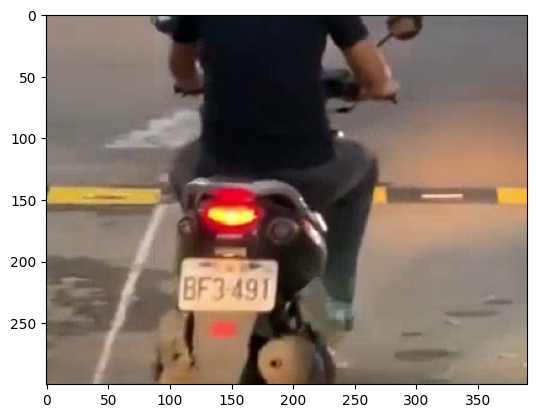

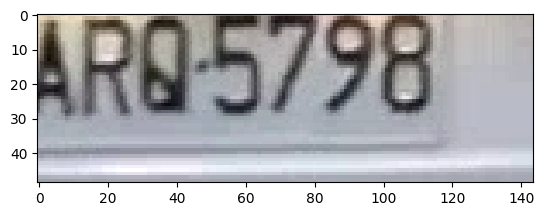

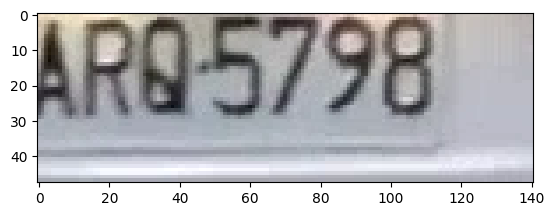

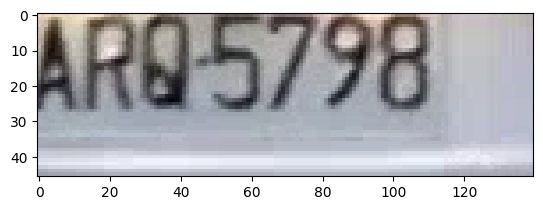

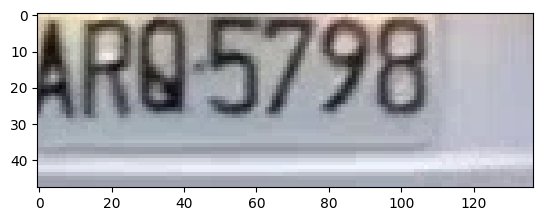

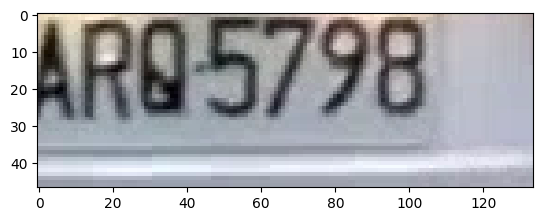

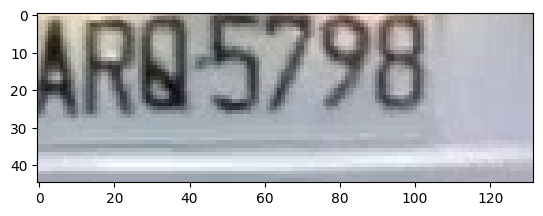

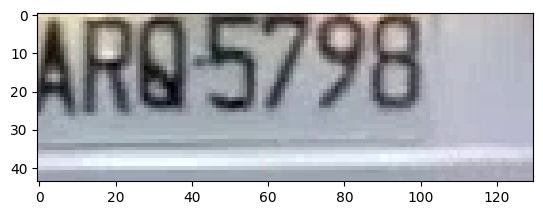

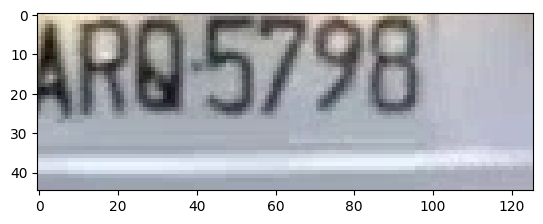

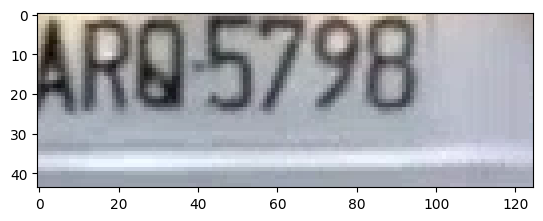

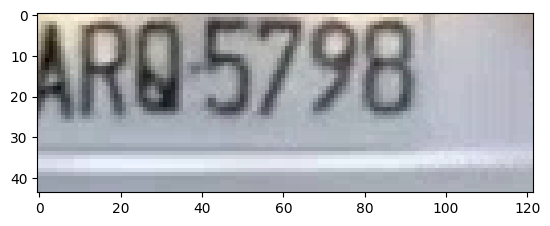

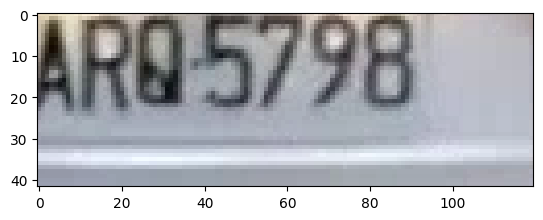

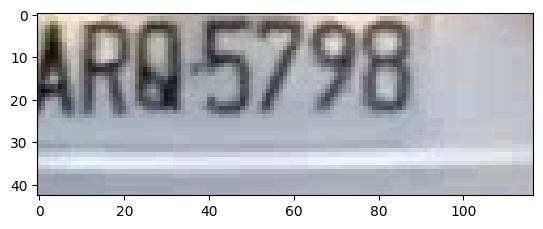

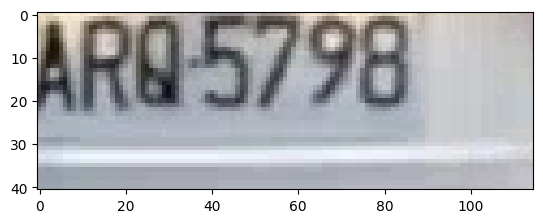

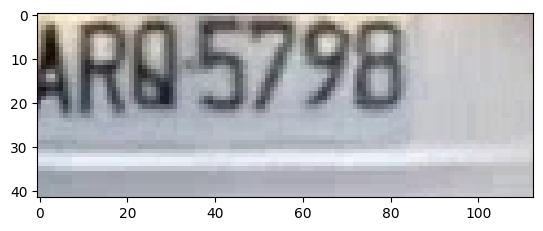

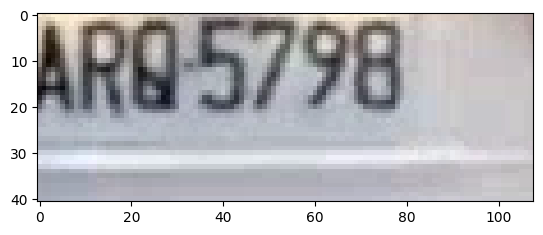

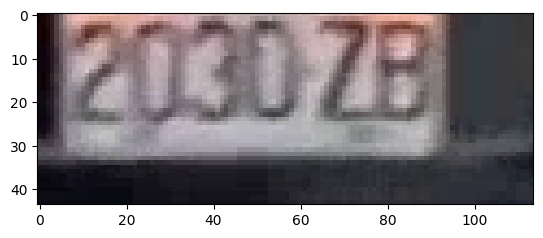

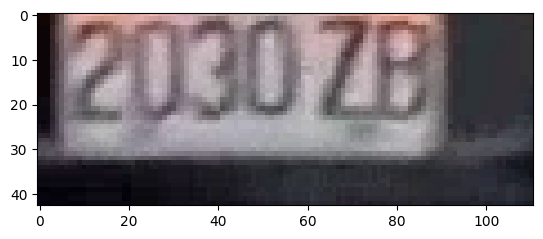

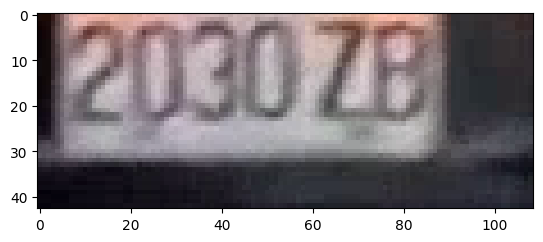

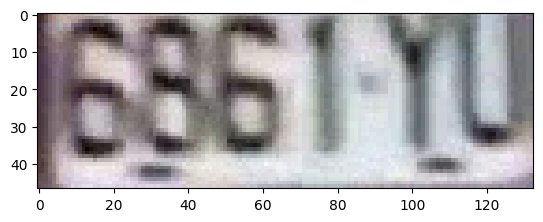

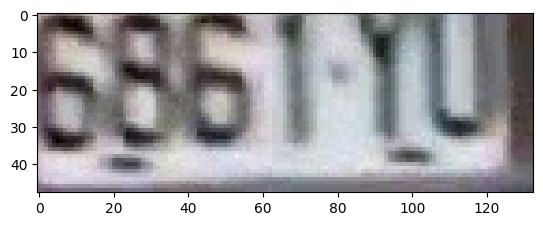

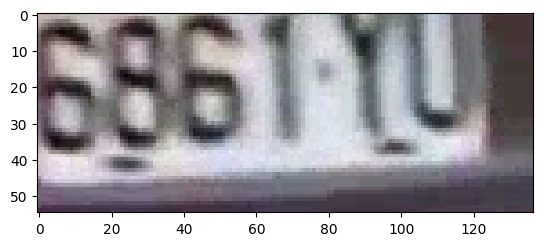

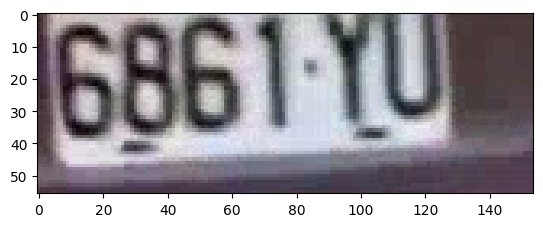

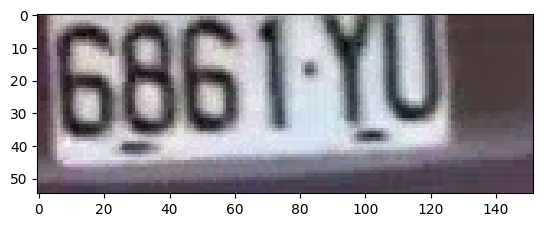

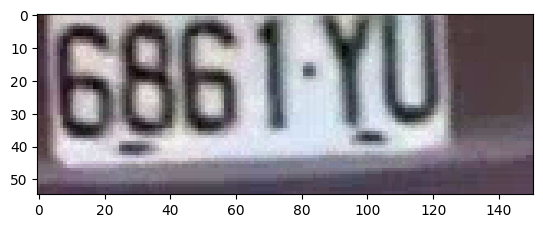

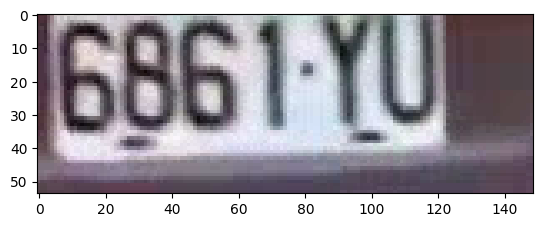

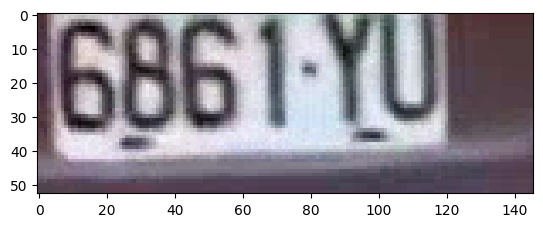

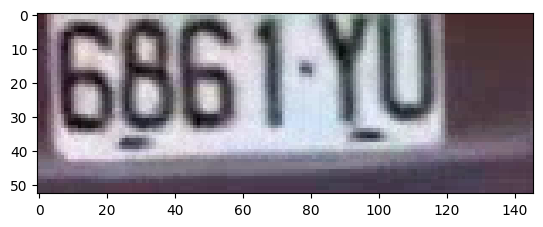

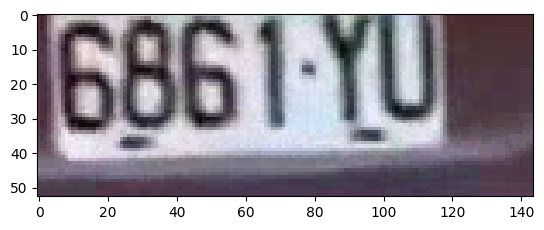

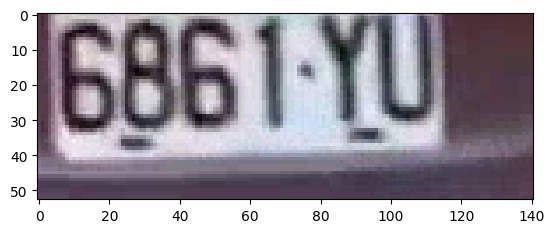

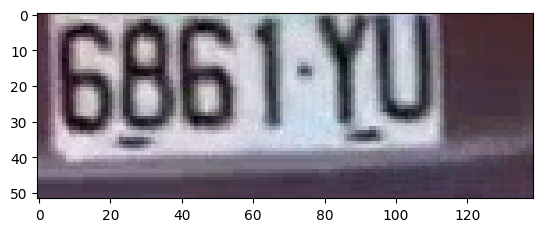

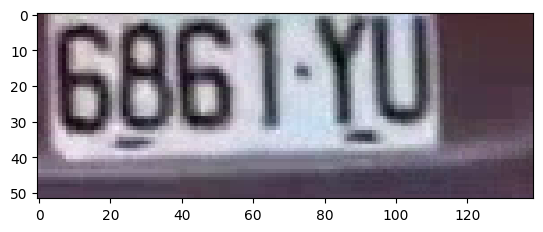

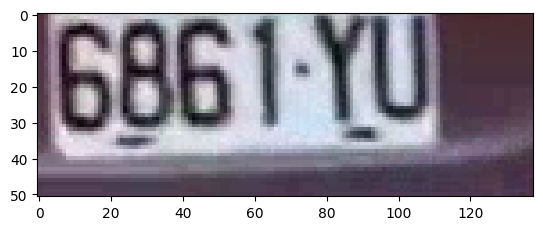

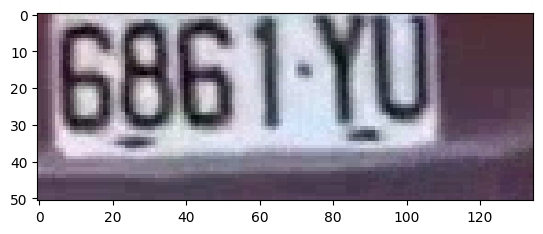

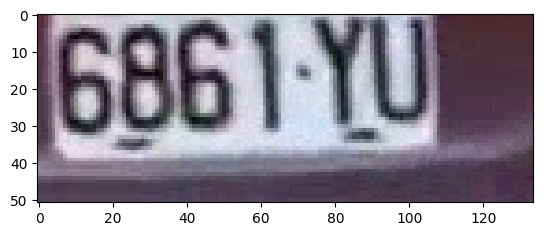

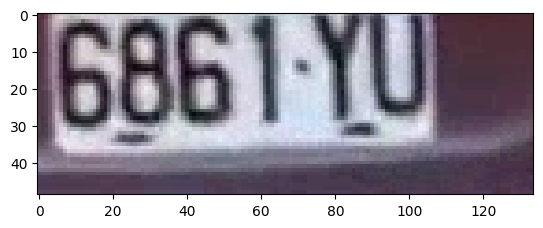

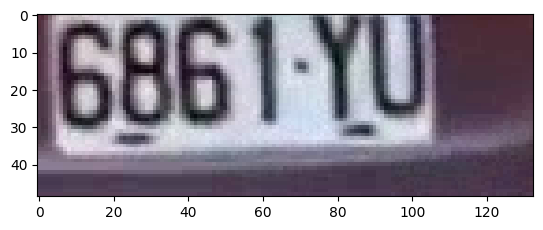

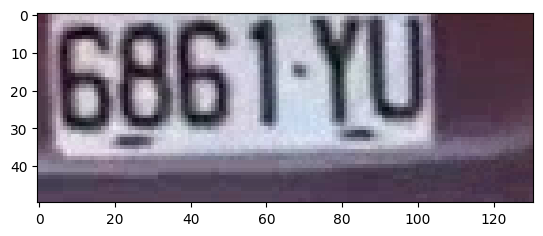

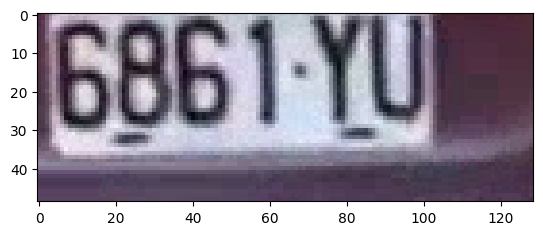

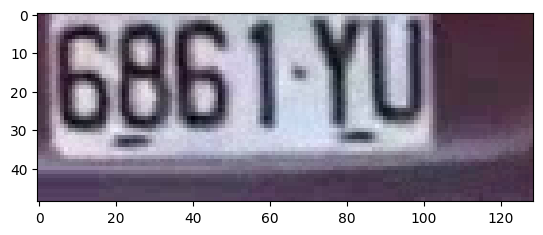

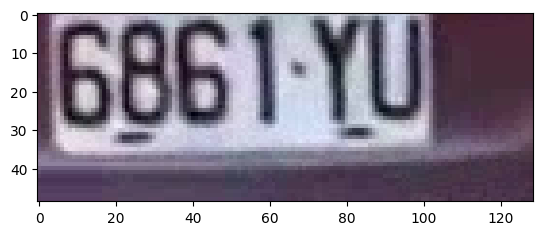

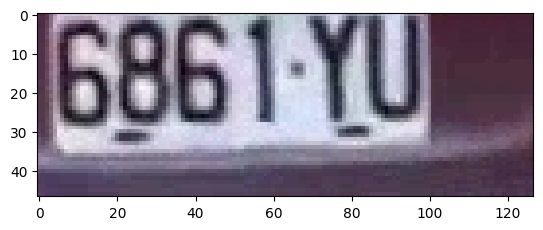

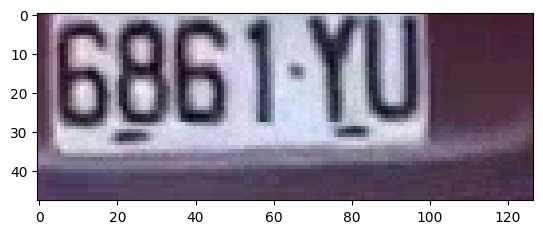

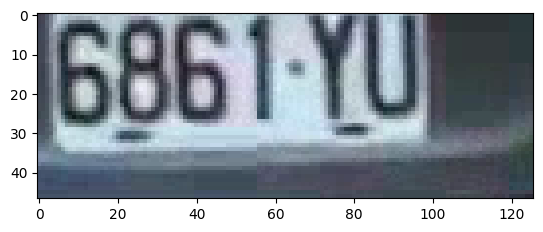

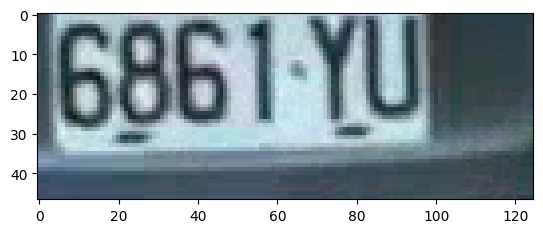

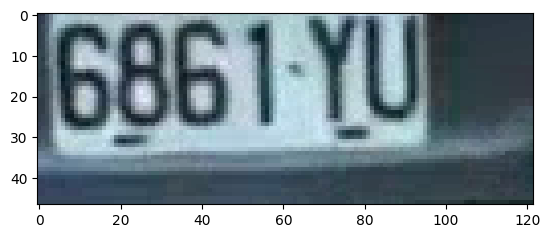

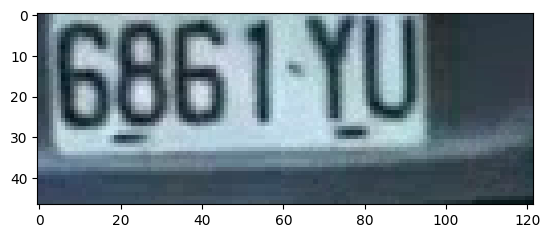

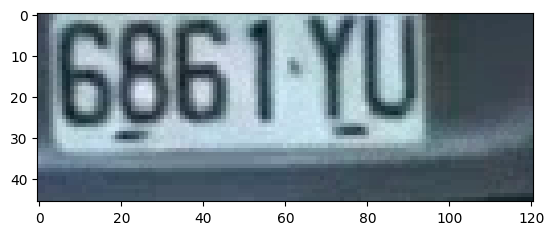

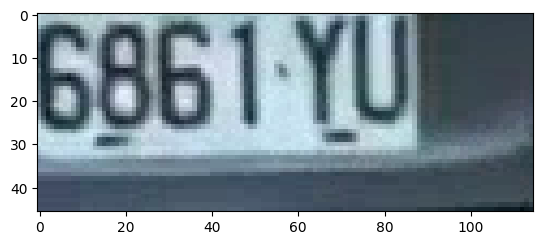

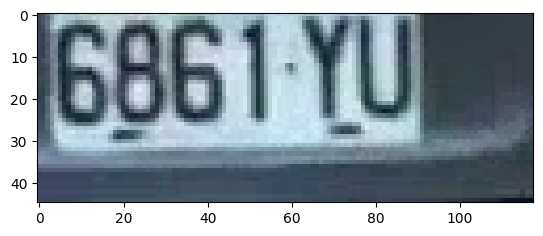

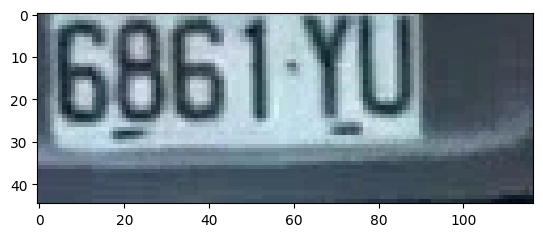

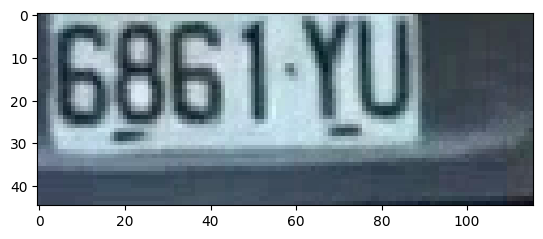

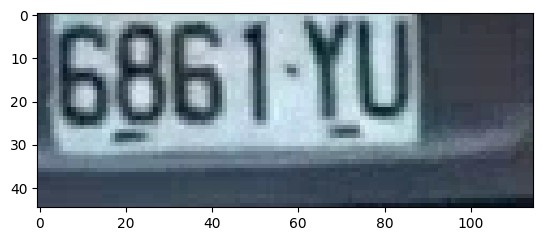

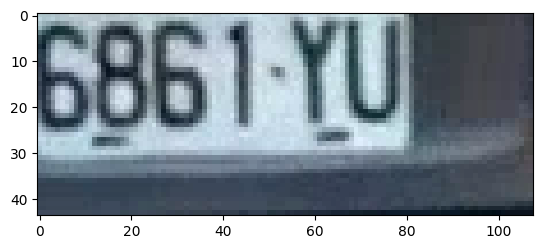

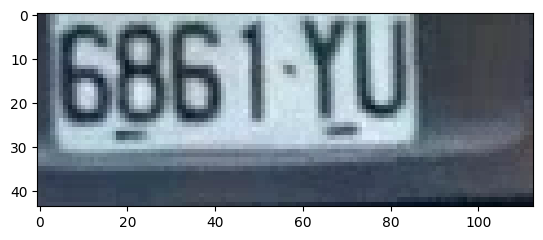

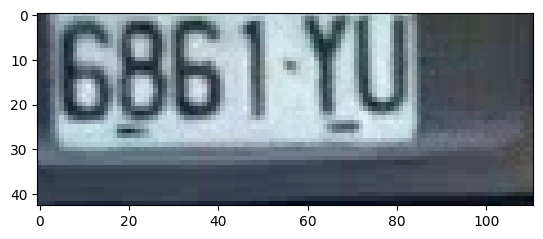

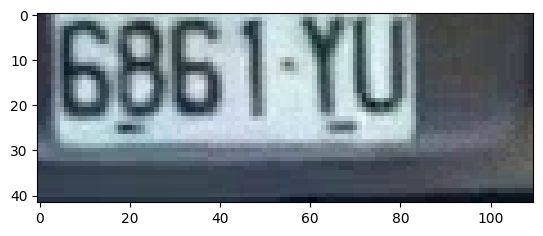

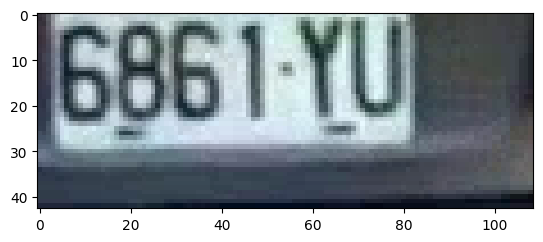

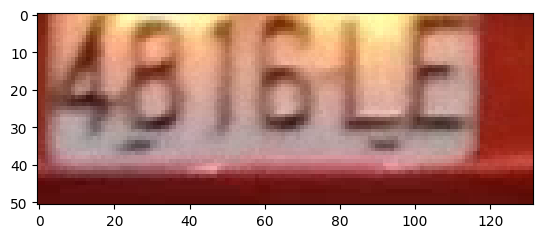

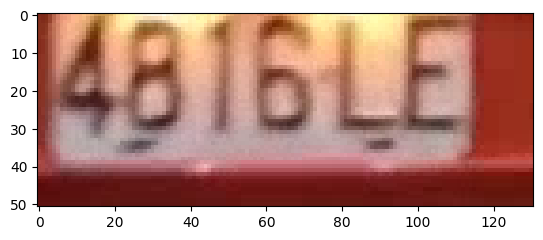

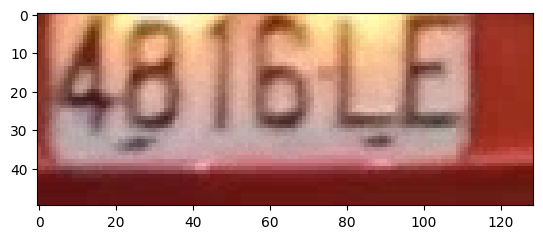

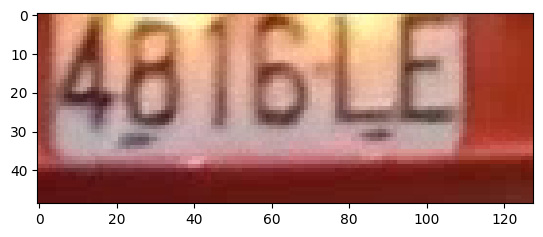

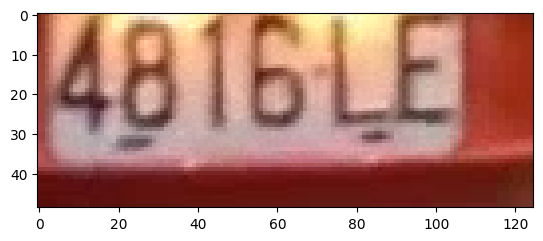

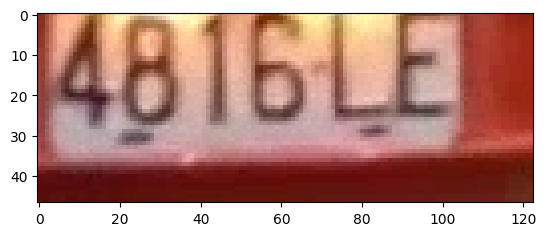

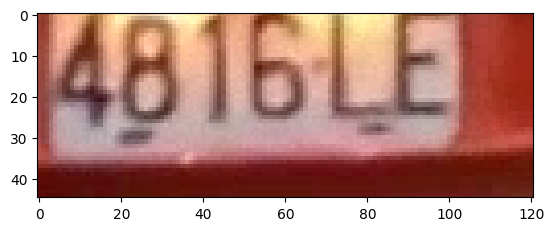

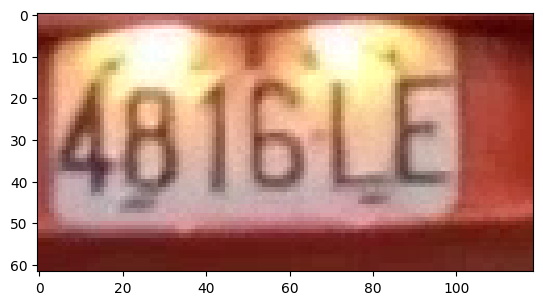

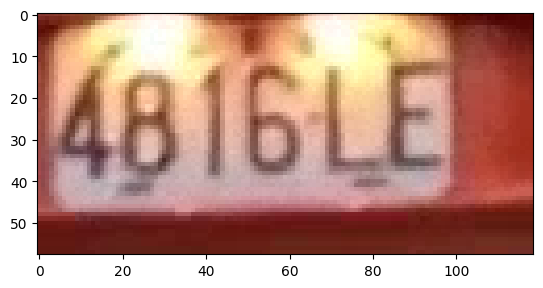

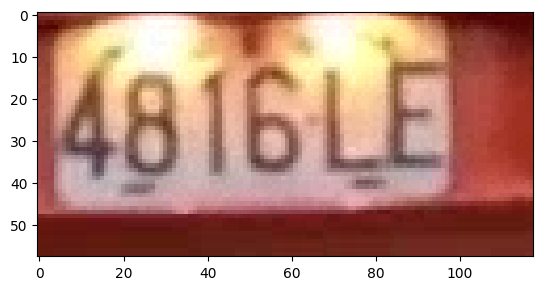

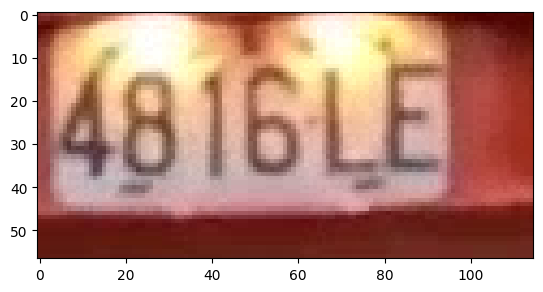

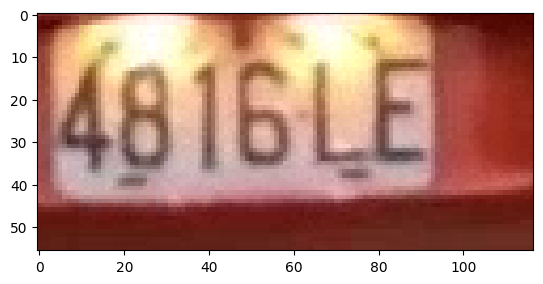

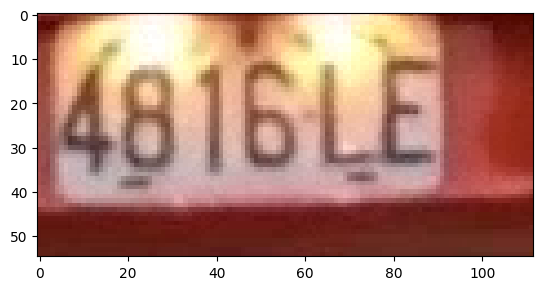

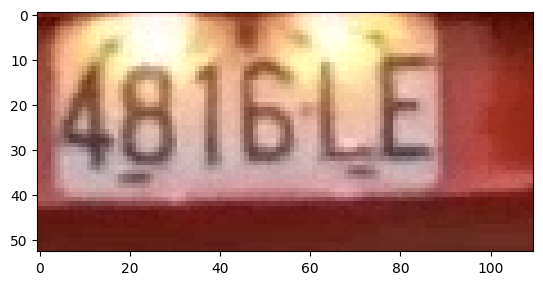

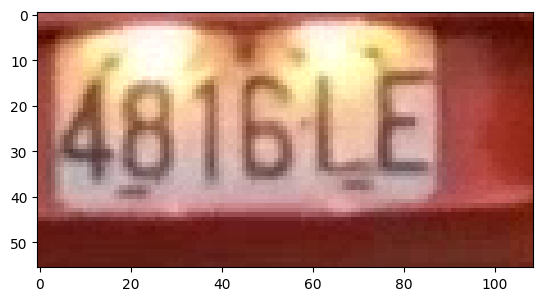

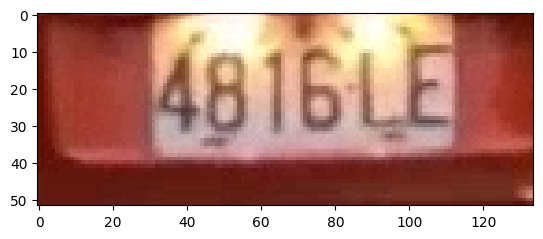

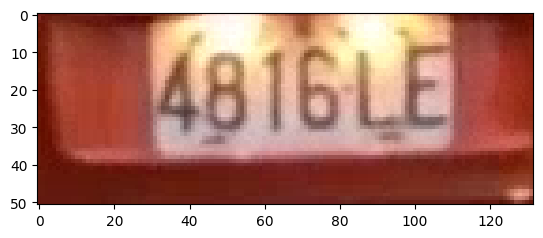

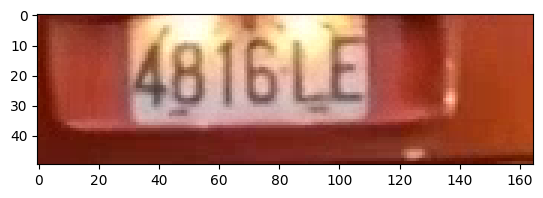

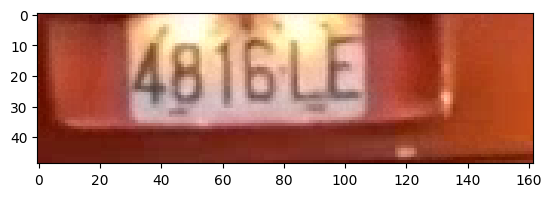

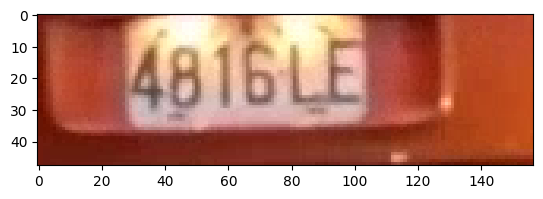

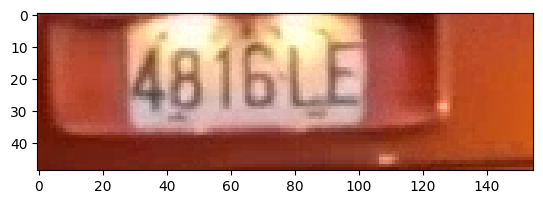

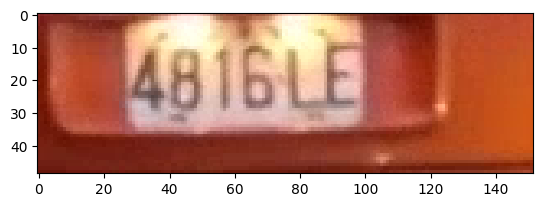

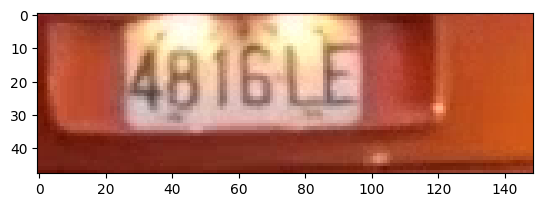

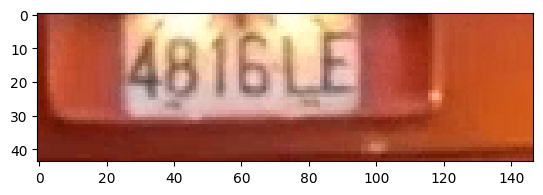

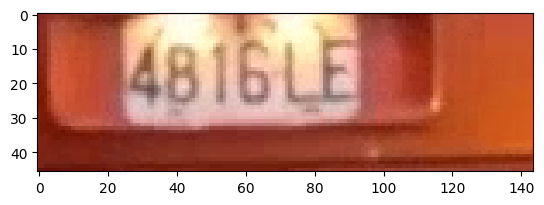

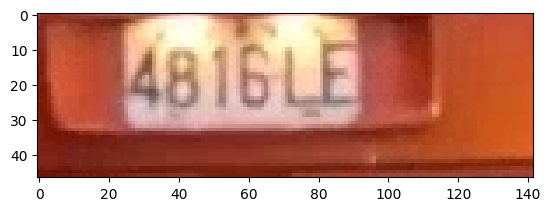

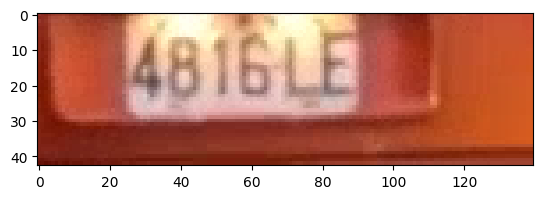

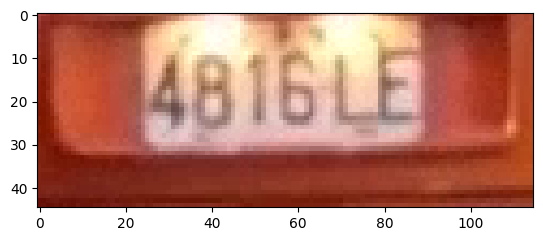

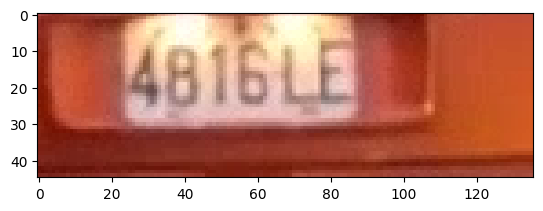

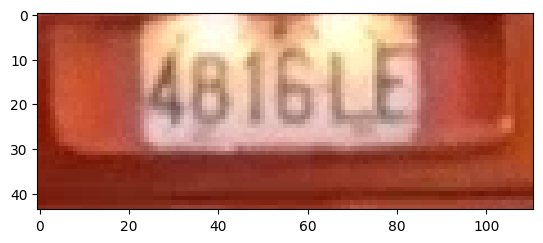

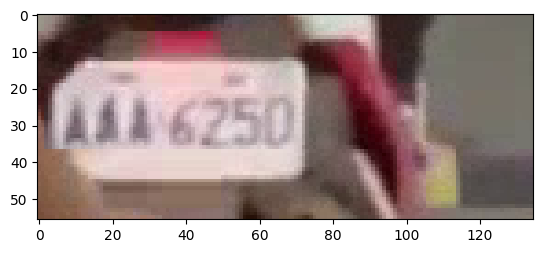

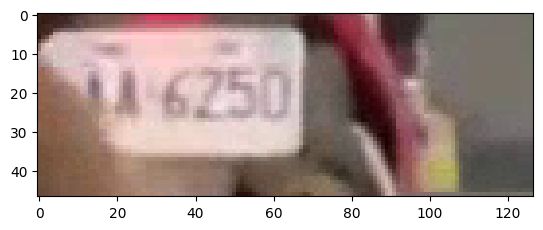

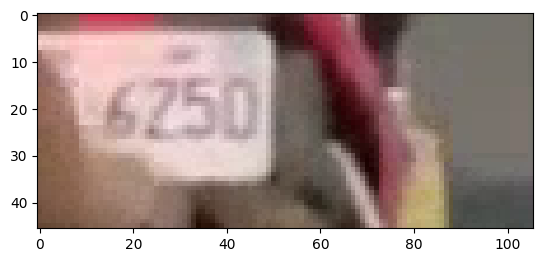

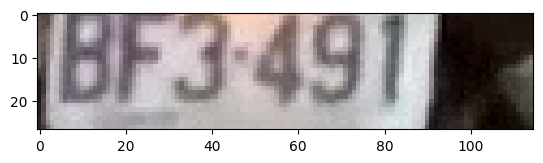

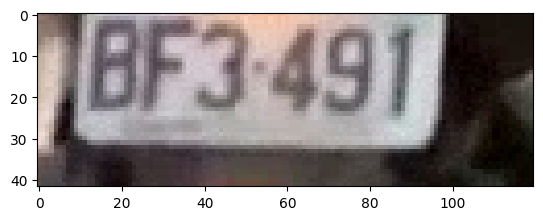

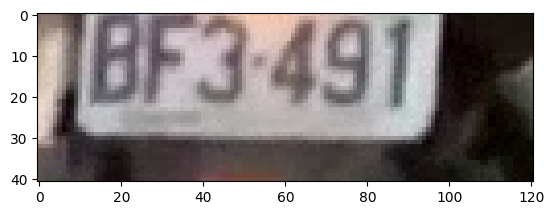

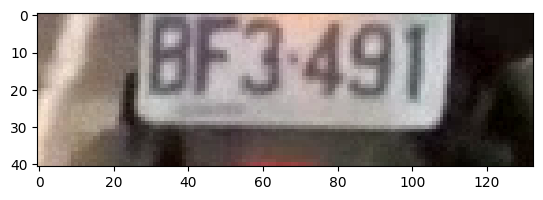

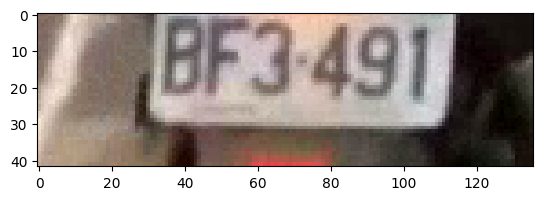

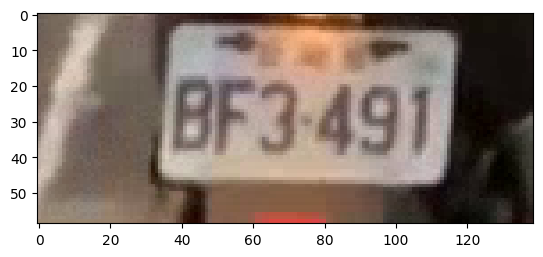

C:\Users\MI701-2070-7\AppData\Local\Temp\ipykernel_12796\1248962539.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cut_width" failed type inference due to: Untyped global name 'data_processing': Cannot determine Numba type of <class 'type'>

File "C:\Users\MI701-2070-7\AppData\Local\Temp\ipykernel_12796\1248962539.py", line 32:
def cut_width(image, center, persent, start, end):
    <source elided>

        width_left = data_processing.findElement(image, start, end, 1)
        ^

  @jit
c:\Users\MI701-2070-7\Anaconda3\envs\newevr\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "cut_width" was compiled in object mode without forceobj=True.

File "C:\Users\MI701-2070-7\AppData\Local\Temp\ipykernel_12796\1248962539.py", line 26:
@jit
def cut_width(image, center, persent, start, end):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\MI701-2070-7\Anaconda3\envs\newevr\lib\site-packages\numba\

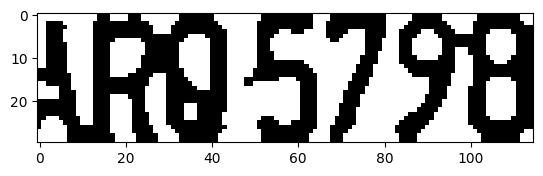

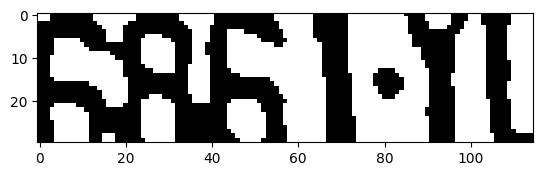

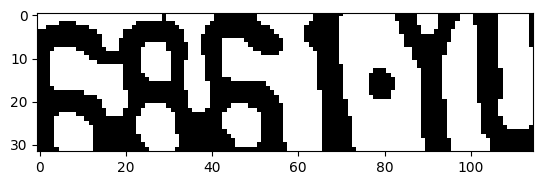

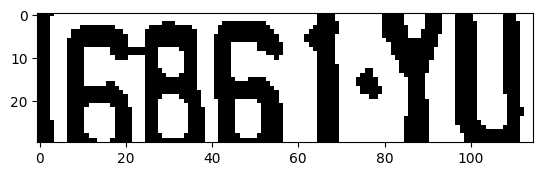

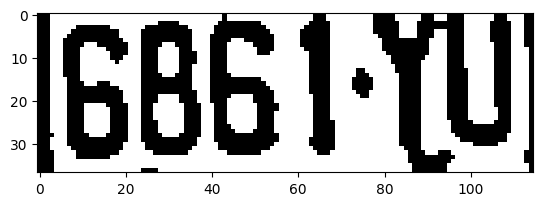

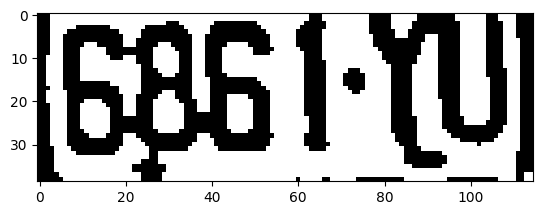

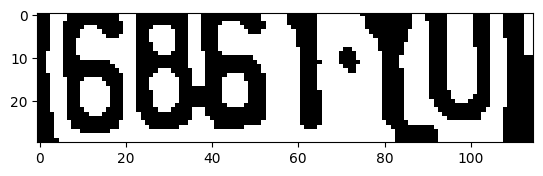

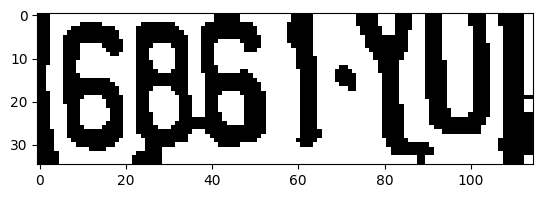

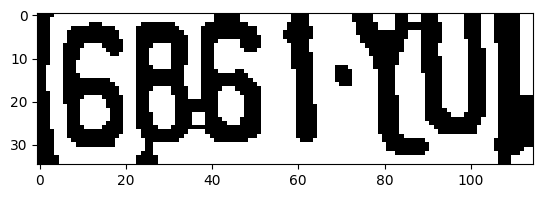

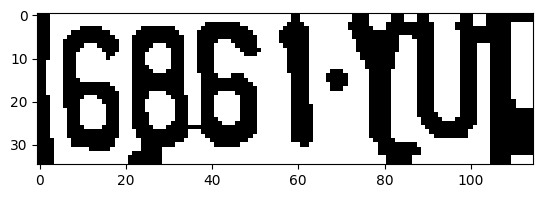

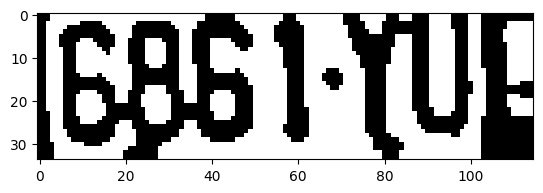

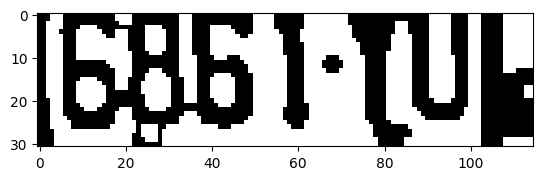

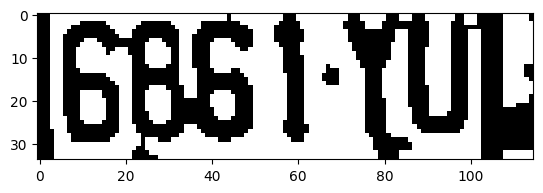

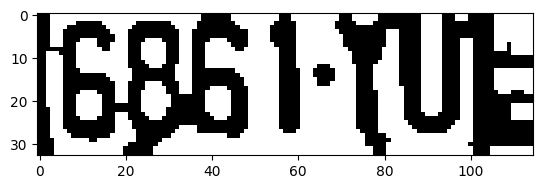

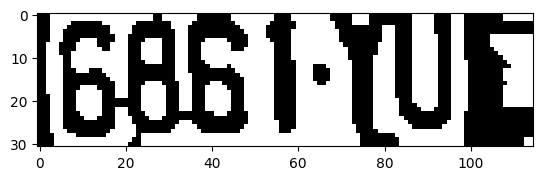

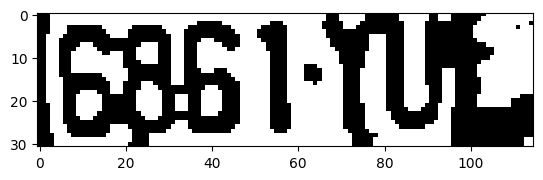

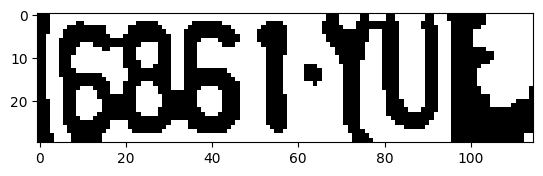

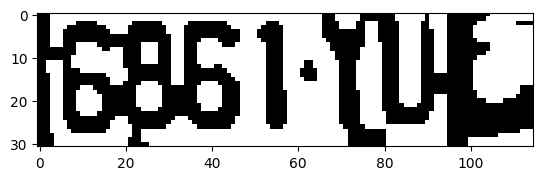

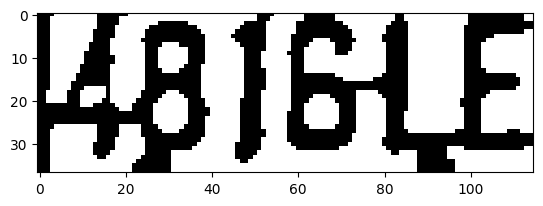

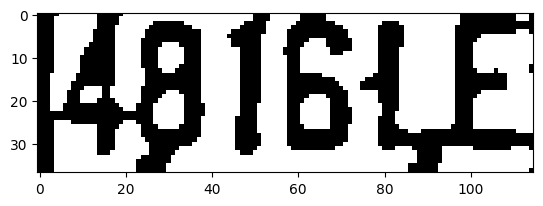

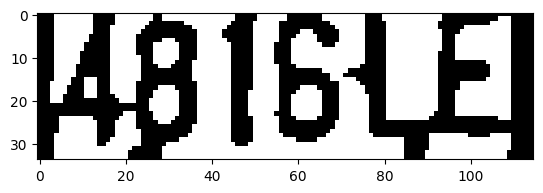

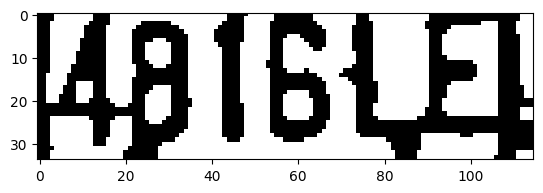

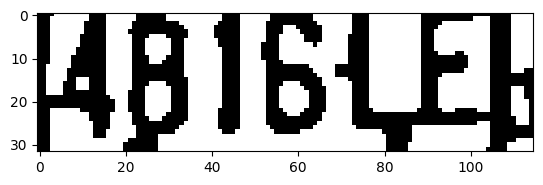

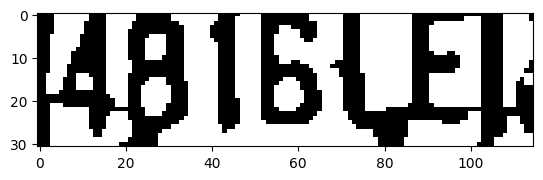

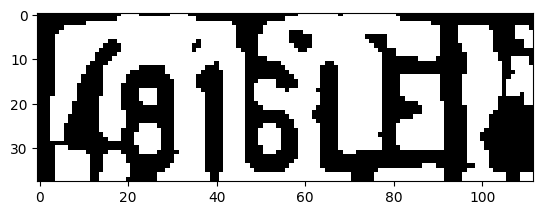

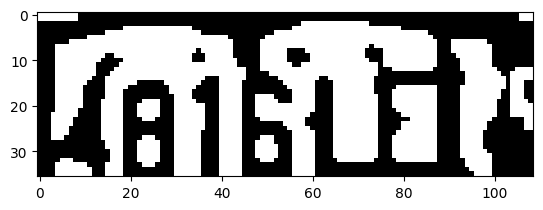

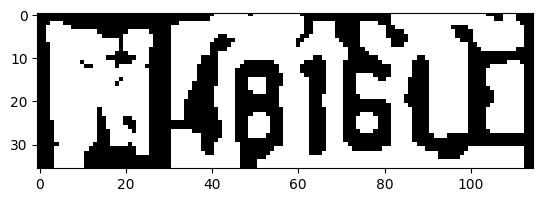

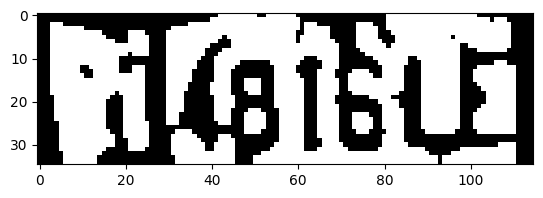

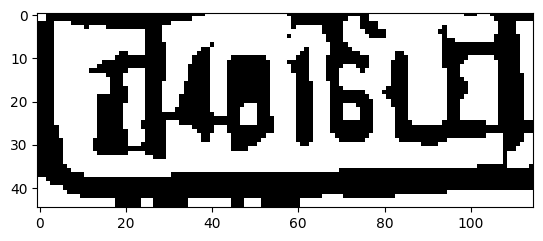

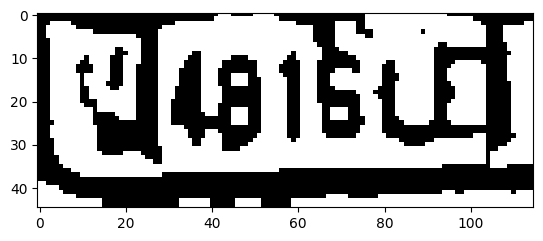

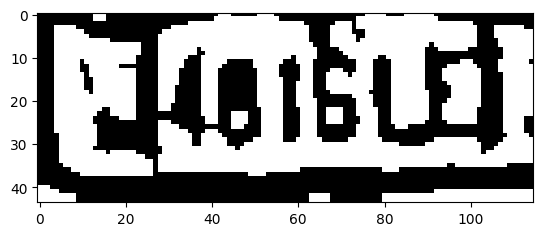

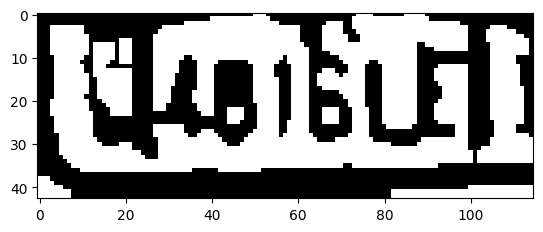

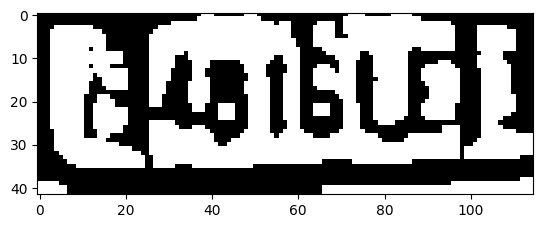

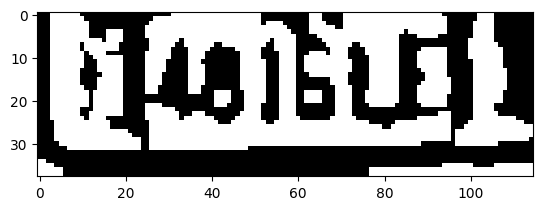

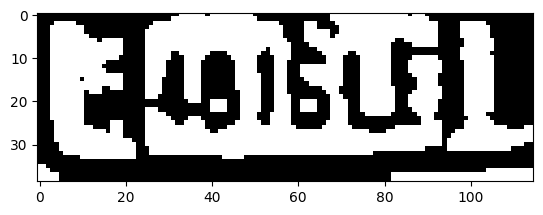

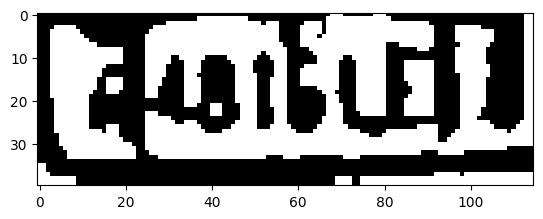

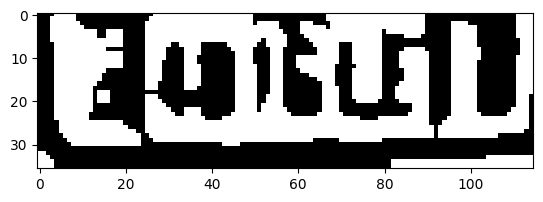

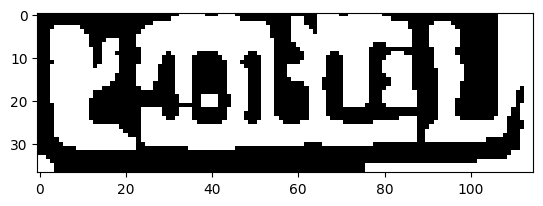

In [1]:
import cv2
import os
import numpy as np
from numba import cuda, jit
import matplotlib.pyplot as plt

@jit
def ToBinary(image, width, height, threshold):
    Newth = 0
    while True:
        O_sum, O_total, B_sum, B_total = 0, 0, 0, 0
        for w in range(width):
            for h in range(height):
                if image[w, h] >= threshold:
                    O_sum += image[w, h]
                    O_total += 1
                else:
                    B_sum += image[w, h]
                    B_total += 1
        Newth = int((O_sum / O_total + B_sum / B_total) / 2)
        if Newth == threshold:
            break
        threshold = Newth
    return Newth
@jit
def cut_width(image, center, persent, start, end):
        width_left = 0
        width_right = 0
        right = left = -1
        next = end - 1

        width_left = data_processing.findElement(image, start, end, 1)
        width_right = data_processing.findElement(image, next, end - 1, -1)

        while True:
            if right != -1:
                width_right = right
            if left != -1:
                width_left = left

            proleft = int(center[0]) - width_left
            proright = width_right - int(center[0])
            if (proright <= 0 or proleft <= 0) or (left == -1 or right == -1):
                proportion = persent
            else:
                proportion = int(proleft / proright)
            
            if proportion < persent:
                if proleft > proright:
                    left = data_processing.findElement(image, width_left + 1, image.shape[1], 1)
                else:
                    right = data_processing.findElement(image, width_right - 1, -1, -1)

            elif proportion > persent:
                if proleft > proright:
                    right = data_processing.findElement(image, width_right - 1, -1, -1)
                else:
                    left = data_processing.findElement(image, width_left + 1, image.shape[1], 1)

            else:
                return width_left

class data_processing:
    @classmethod
    def cutFrame(cln, frame, cutSize):
        image = frame[cutSize[0] : cutSize[1], cutSize[2] : cutSize[3]]
        return image
    
    @classmethod
    def ToGray(cln, frame):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return image

    @classmethod
    def normailzation(cln, image):
        cv2.normalize(image, image, 0, 255, norm_type=cv2.NORM_MINMAX)
        return image

    @classmethod
    def SobelProcessing(cln, frame):
        x = cv2.Sobel(frame, -1, 1, 0)
        y = cv2.Sobel(frame, -1, 0, 1)

        abs_x = cv2.convertScaleAbs(x)
        abs_y = cv2.convertScaleAbs(y)
        result = cv2.addWeighted(abs_x, 0.5, abs_y, 0.5, 0)
        return result

    @classmethod
    def ProcessingBinaryData(cln, image):

        min_val, max_val, min_indx, max_indx = cv2.minMaxLoc(image)
        ThresHold = int((min_val + max_val) / 2)
        NewTH = ToBinary(image, image.shape[0], image.shape [1], ThresHold) 
        ret, thres = cv2. threshold(image, NewTH, 255, cv2.THRESH_BINARY)
        return thres

    @classmethod
    def threshold_processing(cln, image):
        threshold = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
        return threshold

    @classmethod
    def manyMedia(cln, result, times, maskSize):
        for i in range(times):
            result = cv2.medianBlur(result, maskSize)
        return result

    @classmethod
    def erodeAndDilate(cln, image, kernel, dilate_times, erode_times, judge):
        if judge == 1:
            open = cv2.dilate(image, kernel, iterations = dilate_times)
        if judge == 2:
            open = cv2.erode(image, kernel, iterations = erode_times)
        else:
            open = cv2.dilate(image, kernel, iterations = dilate_times)
            open = cv2.erode(open, kernel, iterations = erode_times)
        return open

    @classmethod
    def image_processing(cln, image):
        kernel = np.ones((6, 30), np.uint8)
        open = data_processing.erodeAndDilate(image, kernel, 1, 1, 3)
        # open = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel, iterations = 1)
        open = cv2.morphologyEx(open, cv2.MORPH_OPEN, kernel, iterations = 2)
        return open

    @classmethod
    def connection(cln, image, judge):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity = 4)
        if judge == 1:
            return stats
        else:
            return centroids

    @classmethod
    def findImage(cln, image, processes):
        present = processes[-1, 2] / processes[-1, 3]
        if processes[-1, 4] >= 1600 and (present >= 1.5 and present <= 5.0):
            result = image[processes[-1, 1] - 5 : processes[-1, 1] + processes[-1, 3] + 15, processes[-1, 0] - 5 : processes[-1, 0] + processes[-1, 2] + 25]
            # result = image[processes[-1, 1] - 10 : processes[-1, 1] + processes[-1, 3] + 10, processes[-1, 0] : processes[-1, 0] + processes[-1, 2]]
            if result.size != 0: 
                result = data_processing.normailzation(result)
                data_processing.showImage(result) 
                return result
        return []
    
    @classmethod
    def sharpen(cln, img, sigma=100):    
        # sigma = 5、15、25
        blur_img = cv2.GaussianBlur(img, (0, 0), sigma)
        usm = cv2.addWeighted(img, 1.5, blur_img, -0.5, 0)
        
        return usm

    @classmethod
    def showImage(cln, image):
        output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(output)
        plt.show()
        pass

    @classmethod
    def cutCar(cln, image):
        # image.shape[0] 長
        # image.shape[1] 寬

        persent = image.shape[1] * 0.8
        center = (image.shape[1] / 2, image.shape[0] / 2)
        left = 0
        right = int(center[0]) + 50
        total_high = int(center[1] / 10)
        total_low = int((image.shape[0] - int(center[1])) / 6)
        # print(total_high)
        # print(persent)

        low = high = 0

        for h in range(int(center[1]), -1, -1):
            height = int(center[1]) - h
            white_element = np.sum(image[h, left : right] == 255)

            # print(str(height) + " " + str(white_element) + "\n\n")
            if (white_element == int(image.shape[0]) or white_element >= persent) and height >= total_high:
                high = h
                # cut = cut_width(image, center, (37 / image.shape[1]))
                    # print(cut)
                break

        for h in range(int(center[1]), image.shape[0], 1):
            height = h - int(center[1])
            white_element = np.sum(image[h, left : right] == 255)
            if (white_element == int(image.shape[0]) or white_element >= persent) and height >= total_low:
                low = h
                    # print(cut)
                break
        # rotation = [high, low, left, right]
        # cut = data_processing.cutFrame(image, rotation)
        # print(cut)
        left = cut_width(image, center, (37 / image.shape[1]), left, right)
        rotation = [high, low, left, left + 115]
        cut = data_processing.cutFrame(image, rotation)
        return cut
        # return []
    
    @classmethod
    def findElement(cin, image, start, end, interval):
        persent = image.shape[0] * 0.9
        for left in range(start, end, interval):
            black_element = np.sum(image[0 : image.shape[0], left] == 255)
            if black_element < persent:
                return left
        return -1

    @classmethod
    def rotation_img(cln, image, width, height):
        center = (width / 2, height / 2)
        rotate_matrix = cv2.getRotationMatrix2D(center, -1, 1.0)
        rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
        return rotated_image


class video:
    def __init__(self, filename):
        self.cap = cv2.VideoCapture(filename) # 讀取電腦中的影片

        self.width = []
        self.height = []

        self.image = []
        self.processing_image = []
    def read_video(self):
        counter = 0
        if not self.cap.isOpened():
            print("初始化失敗")
        while True:
            counter += 1
            ret, frame = self.cap.read()
            if not ret:
                print("影片播放完畢")
                break
            size = [200, 500, 200, 590]
            frame = data_processing.cutFrame(frame, size)

            cv2.imshow("output", frame)
            if cv2.waitKey(1) == ord('q'):
                break

            if counter % 2 == 0 and counter != 0 or counter == 899:
                self.image.append(frame)
        
        data_processing.showImage(self.image[-1])
        cv2.destroyAllWindows()
    def image_processing(self):  
        i = 0
        while i < len(self.image):            
            # 灰階
            gray = data_processing.ToGray(self.image[i])
            # 所貝爾
            sobel = data_processing.SobelProcessing(gray)
            # 均值二值化
            binary = data_processing.ProcessingBinaryData(sobel)
            # 中值濾波
            media = data_processing.manyMedia(binary, 4, 3)
            # 侵蝕擴張
            processing = data_processing.image_processing(media)
            # 查找連通
            connection = data_processing.connection(processing, 1)
            width = connection[-1, 2]
            height = connection[-1, 3]
            # 找車牌位置
            result = data_processing.findImage(self.image[i], connection)
            if len(result) != 0:
                # result = data_processing.rotation_img(result, width, height)
                self.processing_image.append(result)
            i += 1

        for i in range(len(self.processing_image)):
            # 灰階
            gray_car = data_processing.ToGray(self.processing_image[i])
            # cv2.normalize(gray_car, gray_car, 0, 255, cv2.NORM_MINMAX)
            # 中值濾波
            media = data_processing.manyMedia(gray_car, 9, 3)
            # 自適應二值化
            binary = data_processing.threshold_processing(media)
            # 中值濾波
            # binary = data_processing.manyMedia(binary, , 3)
            # data_processing.showImage(binary)
            # cutWidth = cut_width(binary, center, persent, 1)
            
            # 取邊框
            cut_image = data_processing.cutCar(binary)
            # print(cut_image.shape)
            # # break
            # cv2.normalize(binary, binary, 0, 255, cv2.NORM_MINMAX)
            if len(cut_image) != 0 and cut_image.shape[0] >= 30:
                kernel = np.ones((3, 3), np.uint8)
                cut_image = cv2.morphologyEx(cut_image, cv2.MORPH_OPEN, kernel, iterations = 1)
                data_processing.showImage(cut_image)

                # center = (cut_image.shape[1] / 2, cut_image.shape[0] / 2)
                # cutWidth = cut_width(cut_image, center, 5, 13, 15)
                # rotation = [0, cut_image.shape[0], cutWidth, cutWidth + 15]
                # cut_image = data_processing.cutFrame(cut_image, rotation)
                # print(cut_image.shape)
                # data_processing.showImage(cut_image)
                # for width in range(0, cut_image.shape[1] - 14, 10):
                #     center = (cut_image.shape[1] / 2, cut_image.shape[0] / 2)
                #     cutWidth = cut_width(cut_image, center, 5, width, width + 5)
                #     rotation = [0, cut_image.shape[0], cutWidth, cutWidth + 10]
                #     cut_image = data_processing.cutFrame(cut_image, rotation)
                #     data_processing.showImage(cut_image)
                # break


# Check GPU
# import tensorflow as tf
# print('TensorFlow version:', tf.__version__)
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(physical_devices)
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# os.environ["CUDA_VISIBLE_DEVICES"]='0'
videos = video('車牌辨識verification.mp4')
videos.read_video()
videos.image_processing()


# plt.figure(figsize=(30, 20))
# output = cv2.cvtColor(videos.processing_image[8], cv2.COLOR_BGR2RGB)
# plt.imshow(output)
# plt.show()

# cv2.imshow("output", videos.processing_image[5])
# if cv2.waitKey(10000000) == ord('q'):
#     cv2.destroyAllWindows()

# print(videos.processing_image[30])